# Jackknife Resampling Tests

- Divide observations into 'patches'
- Leave out 1 patch and calculate parameter using the rest of the patches 

In [2]:
import des_functions
import treecorr
import numpy as np
import astropy.io.fits as fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.stats.jackknife as jackknife
import matplotlib.pyplot as plt
from more_itertools import locate
data_dir = '/home/b7009348/projects/WGL_Project/DES-data/'
treecorr.__version__

'4.2.0'

In [17]:
# paths to required files
data_dir = '/home/b7009348/projects/WGL_Project/DES-data/'
lens_file = 'DES_Y1A1_Lenses_z=0.3-0.45.fits'
source_file = 'y1_mcal_shapes_matched.fits'
source_Zs = 'y1a1-gold-mof-badregion_BPZ.fits'

### Jackknife using indexing on patches attribute of catalogues

In [28]:
# define bin and scale params
nbins=20
npatches=20
theta_min=2.5
theta_max=250

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=npatches)

del data, ra_l, dec_l, w_l

gammaT_patches = np.zeros([npatches, nbins])
theta_patches = np.zeros_like(gammaT_patches)

#loop to exclude 1 patch at a time
for i in range(npatches):
    
    # read in randoms data and create treecorr catalogue
    with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
        data = hdu[1].data
        indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
        ra_r = data['RA'][indexes]
        dec_r = data['dec'][indexes]

    # define patches based on patches from lens catalogue so all catalogues use the same patches    
    cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

    del data, ra_r, dec_r

    del indexes

    # read in metacalibration data
    with fits.open(data_dir+source_file) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R11 = data['R11'] # e1-e1
    
    # responsivity values for this patch
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=R11, g1=e1, g2=e2, patch_centers=cat_l.patch_centers)

    del data, ra_s, dec_s, e1, e2, R11

    print('Total catalogues created, proceeding with jackknife...')

    #locate patch in catlogues
    l_indexes = list(locate(cat_l.patch, lambda x: x != i))
    r_indexes = list(locate(cat_r.patch, lambda x: x != i))
    s_indexes = list(locate(cat_s.patch, lambda x: x != i))
    
    print('Patch %g located...' %i)
    
    #create new catalogues with this patch missing
    jk_l = treecorr.Catalog(ra=cat_l.ra[l_indexes], dec=cat_l.dec[l_indexes], ra_units='rad', dec_units='rad', w=cat_l.w[l_indexes])
    
    jk_r = treecorr.Catalog(ra=cat_r.ra[r_indexes], dec=cat_r.dec[r_indexes], ra_units='rad', dec_units='rad', w=cat_r.w[r_indexes])
    
    jk_s = treecorr.Catalog(ra=cat_s.ra[s_indexes], dec=cat_s.dec[s_indexes], ra_units='rad', dec_units='rad', g1=cat_s.g1[s_indexes], 
                                g2=cat_s.g2[s_indexes])
    
    R = np.mean(cat_s.r[s_indexes])

    
    print('Number of sources in patch: %f' %jk_s.nobj)
    print('Total number of sources: %f' %cat_s.nobj)
    
    del l_indexes, r_indexes, s_indexes, cat_r, cat_s, 
    
    # do correlations with lenses
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(jk_l, jk_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(jk_r, jk_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    gammaT_patches[i,:] = 1.0/R * (xi_l - xi_r)
    theta_patches[i,:] = np.exp(ng.meanlogr)
    print(gammaT_patches[i,:])
    
    print('Correlation calculation complete, saving data...')

    del jk_l, jk_s, jk_r, ng, rg

Total catalogues created, proceeding with jackknife...
Patch 0 located...
Number of sources in patch: 16766434.000000
Total number of sources: 17865244.000000
[1.23866288e-03 1.03260796e-03 7.69905714e-04 6.60032741e-04
 4.99371333e-04 3.22482287e-04 2.79207326e-04 2.03240389e-04
 1.99601325e-04 1.84667745e-04 1.32757404e-04 1.04002715e-04
 1.11663549e-04 8.29482433e-05 7.17673040e-05 5.97707346e-05
 5.59862255e-05 4.03352946e-05 3.58607813e-05 4.05506312e-05]
Correlation calculation complete, saving data...
Total catalogues created, proceeding with jackknife...
Patch 1 located...
Number of sources in patch: 17191165.000000
Total number of sources: 17865244.000000
[1.16902708e-03 1.10705885e-03 8.22470045e-04 6.60212252e-04
 5.01713278e-04 4.05203885e-04 2.80424896e-04 2.26482458e-04
 2.00894989e-04 1.88809751e-04 1.22761106e-04 1.13531964e-04
 1.25395360e-04 8.27578846e-05 7.36642689e-05 7.35918670e-05
 5.86919640e-05 4.67247064e-05 3.95947669e-05 4.15608859e-05]
Correlation calculati

In [33]:
gammaT = np.zeros([nbins])
var = np.zeros_like(gammaT)
boost = np.zeros_like(gammaT)
boost_var = np.zeros_like(gammaT)
theta = np.zeros_like(gammaT)
for i in range(nbins):
    
    # rows represent patches, columns ang. sep. bins
    gammaT[i] = 1.0/npatches * np.sum(gammaT_patches[:,i]) # sum over all patches
    #boost[i] = 1.0/npatches * np.sum(boost_patches[:,i])
    
    # each row of GammaT_patches corresponds to an x_i estimate
    var[i] = (npatches-1)/npatches * np.sum((gammaT_patches[:,i] - gammaT[i])**2) # sum over x_i - x
    #boost_var[i] = 1.0/(npatches-1) * np.sum((boost_patches[:,i] - boost[i])**2)
    
    # calculate average theta for all patches
    theta[i] = 1.0/npatches * np.sum(theta_patches[:,i])
    
sig = np.sqrt(var)
#boost_sig = np.sqrt(boost_var)

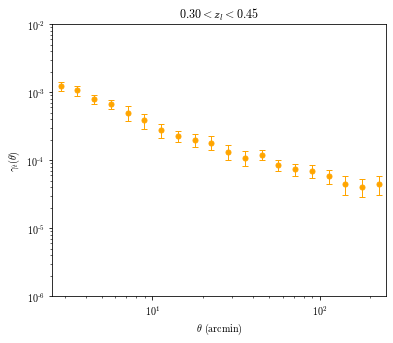

In [34]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

plt.figure(figsize=[6,5])
plt.errorbar(theta, gammaT, yerr=sig, lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{t}(\theta)$')
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('jackknife_zl=0.3-0.45_zs=all.png', dpi=300)

In [31]:
print(sig)

[2.04023559e-04 1.81305772e-04 1.15974321e-04 1.02331026e-04
 1.24703426e-04 9.59873294e-05 6.16049849e-05 4.15807569e-05
 4.04481190e-05 4.26528204e-05 3.29378915e-05 2.70700583e-05
 2.04708527e-05 1.53998894e-05 1.41742889e-05 1.56145013e-05
 1.30722319e-05 1.40201636e-05 1.13775105e-05 1.42519060e-05]


In [32]:
print(gammaT)

[1.22785963e-03 1.06801546e-03 7.95670738e-04 6.66545550e-04
 5.00061986e-04 3.83017375e-04 2.76024244e-04 2.28199334e-04
 1.97963121e-04 1.81147622e-04 1.32171055e-04 1.08790299e-04
 1.19819977e-04 8.49485772e-05 7.34003579e-05 6.94029747e-05
 5.76951256e-05 4.44117064e-05 4.04974808e-05 4.50973660e-05]


In [24]:
print(gammaT_patches)

[[1.17859945e-03 1.06829600e-03 8.06969043e-04 6.80858652e-04
  4.81987525e-04 3.77662966e-04 2.65934221e-04 2.51840313e-04
  1.97930479e-04 1.69968756e-04 1.27574916e-04 1.13184982e-04
  1.18045327e-04 8.98949757e-05 7.31176703e-05 6.94991733e-05
  5.39347977e-05 4.45809047e-05 4.06891679e-05 4.26334358e-05]
 [1.17859945e-03 1.06829600e-03 8.06969043e-04 6.80858652e-04
  4.81987525e-04 3.77662966e-04 2.65934221e-04 2.51840313e-04
  1.97930479e-04 1.69968756e-04 1.27574916e-04 1.13184982e-04
  1.18045327e-04 8.98949757e-05 7.31176703e-05 6.94991733e-05
  5.39347977e-05 4.45809047e-05 4.06891679e-05 4.26334358e-05]
 [1.17859945e-03 1.06829600e-03 8.06969043e-04 6.80858652e-04
  4.81987525e-04 3.77662966e-04 2.65934221e-04 2.51840313e-04
  1.97930479e-04 1.69968756e-04 1.27574916e-04 1.13184982e-04
  1.18045327e-04 8.98949757e-05 7.31176703e-05 6.94991733e-05
  5.39347977e-05 4.45809047e-05 4.06891679e-05 4.26334358e-05]
 [1.17859945e-03 1.06829600e-03 8.06969043e-04 6.80858652e-04
  4.8

In [ ]:
plt.figure(figsize=[6,5])
plt.errorbar(theta_final, boost, yerr=boost_sig, lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'B($\theta$)')
plt.title(r'$0.30 < z_{l} < 0.45$')
plt.legend([r'$0.20<z_{s}<0.43$', r'$0.43<z_{s}<0.63$', r'$0.63<z_{s}<0.90$', r'$0.90<z_{s}<1.30$'])
plt.xscale('log')
plt.ylim([0.98,1.12])
plt.xlim([2.5,250])
plt.savefig('jackknife_boosts_zl=0.3-0.45.png')